In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from scipy.stats import entropy

### Preparing Data

In [8]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [9]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [10]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Model

In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [12]:
import tensorflow as tf

print(tf.test.is_gpu_available())
torch.cuda.get_device_name(torch.device('cuda:0'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


'NVIDIA GeForce RTX 2070'

True


'NVIDIA GeForce RTX 2070'

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#writer = SummaryWriter('runs/fashion_mnist_experiment_1')

#### Pred Hist

In [14]:
prediction_history = torch.zeros(0,60000,10) ##
prediction_history = prediction_history.to(device) ##


### Train Function

In [15]:
def train(dataloader, model, loss_fn, optimizer):

  global prediction_history ##

  size = len(dataloader.dataset)
  model.train()

  epoch_pred=torch.zeros(0,10) ### 10 = class number
  epoch_pred = epoch_pred.to(device) ###

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)

    ##records = aum_calculator.update(pred, y, classes) ### From Paper

    epoch_pred=torch.cat((epoch_pred,pred)) ###

    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  prediction_history =torch.cat((prediction_history,torch.unsqueeze(epoch_pred, 0)))#

### Test Function

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Training & Evaluating Model

In [17]:
epochs = 100
#print(prediction_history.shape)

prediction_history = torch.zeros(0,60000,10) ##
prediction_history = prediction_history.to(device) ##

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305941  [    0/60000]
loss: 2.291821  [ 6400/60000]
loss: 2.272570  [12800/60000]
loss: 2.269154  [19200/60000]
loss: 2.244975  [25600/60000]
loss: 2.225196  [32000/60000]
loss: 2.229508  [38400/60000]
loss: 2.199445  [44800/60000]
loss: 2.197681  [51200/60000]
loss: 2.161146  [57600/60000]
Test Error: 
 Accuracy: 52.4%, Avg loss: 2.162199 

Epoch 2
-------------------------------
loss: 2.173237  [    0/60000]
loss: 2.159381  [ 6400/60000]
loss: 2.108838  [12800/60000]
loss: 2.124221  [19200/60000]
loss: 2.065753  [25600/60000]
loss: 2.023171  [32000/60000]
loss: 2.038417  [38400/60000]
loss: 1.968379  [44800/60000]
loss: 1.967083  [51200/60000]
loss: 1.886254  [57600/60000]
Test Error: 
 Accuracy: 58.3%, Avg loss: 1.896435 

Epoch 3
-------------------------------
loss: 1.927954  [    0/60000]
loss: 1.893491  [ 6400/60000]
loss: 1.788913  [12800/60000]
loss: 1.823159  [19200/60000]
loss: 1.708018  [25600/60000]
loss: 1.669285  [32000/600

In [18]:
model.eval()
x, y = test_data[0][0], test_data[0][1]

if device =="cuda":
  x=x.to(device)

with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Data Cartography

In [19]:
prediction_history.shape

torch.Size([100, 60000, 10])

In [20]:
num_pred_hist=(torch.softmax(prediction_history,dim=2)).detach().cpu().numpy()

In [21]:
confidence_means=torch.mean(torch.softmax(prediction_history, dim = 2),0)
std=torch.std(torch.softmax(prediction_history, dim = 2),0)
targets=training_data.targets.cpu().numpy()

In [22]:
df = pd.DataFrame(targets, columns=["Label"])
df["Confidence Mean"] = np.take_along_axis(confidence_means.detach().cpu().numpy(),np.expand_dims(targets, axis=1),axis=1)
df["std"] = np.take_along_axis(std.detach().cpu().numpy(),np.expand_dims(targets, axis=1),axis=1)

In [23]:
epoch_pred=prediction_history.argmax(2).permute(1,0).cpu().numpy()
targetxE=np.tile(targets,(epochs,1)).transpose() ### label matrix x epoch num
print(epoch_pred)
correctness_matrix = (targetxE==epoch_pred).astype(int)
df["correctness"]= correctness_matrix.sum(axis=1)/(epochs)

[[9 9 9 ... 9 9 9]
 [9 0 0 ... 0 0 0]
 [8 3 3 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [0 0 0 ... 0 0 0]
 [8 7 7 ... 5 5 5]]


### Data Cartography

In [24]:
prediction_history.shape

torch.Size([100, 60000, 10])

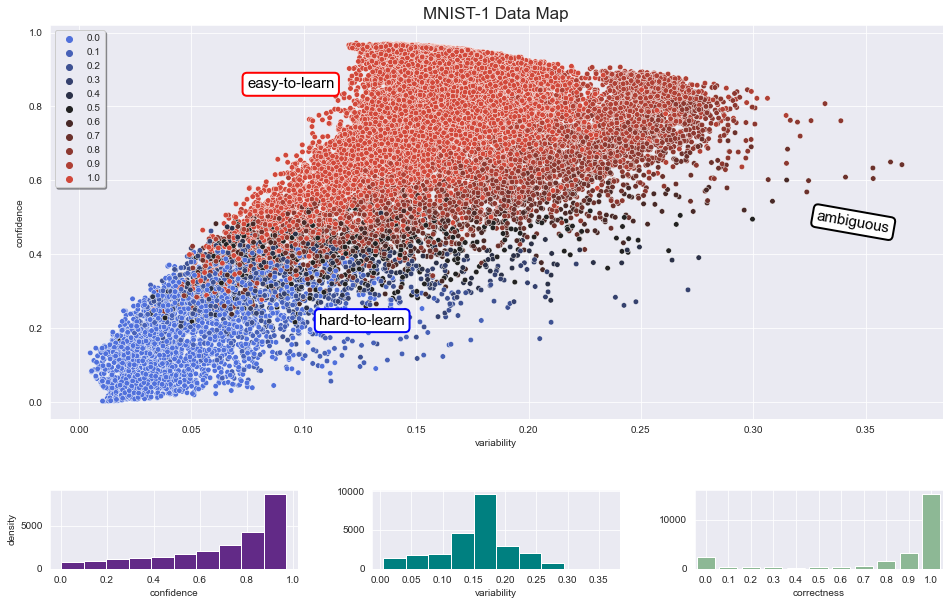

In [28]:
scatter_it(df, model="MNIST",title='1', show_hist=True)

## Clustering

### K-Means Clustering

In [29]:
df.head()

,Label,confidence,variability,correctness
0,9,0.938168,0.155927,1.00
1,0,0.930069,0.168931,0.99
2,0,0.204693,0.068780,0.19
3,3,0.230758,0.046030,0.00
4,0,0.091610,0.031115,0.00


In [30]:
from sklearn.cluster import KMeans

In [31]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
df["clusters"] = kmeans.fit_predict(df)


<AxesSubplot:xlabel='variability', ylabel='confidence'>

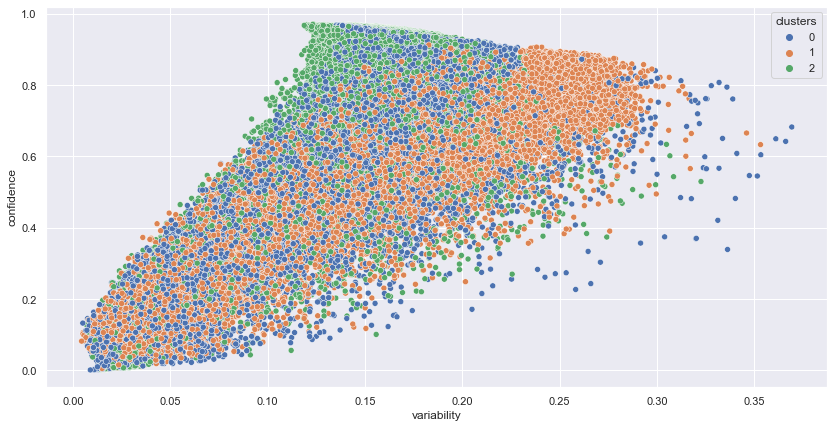

In [32]:
sns.set(rc={'figure.figsize':(14,7)})
sns.scatterplot(data=df, x="variability", y="confidence", hue="clusters", palette="deep")

In [33]:
df.drop(columns=["clusters"],inplace=True)

### Spectral Clustering

In [34]:
from sklearn.cluster import SpectralClustering

speccluster_model = SpectralClustering(n_clusters=3, 
                                       assign_labels='kmeans', # The strategy for assigning labels in the embedding space.
                                       affinity='nearest_neighbors',
                                       random_state=0)
df["clusters"] = speccluster_model.fit_predict(df)
speccluster_label = speccluster_model.labels_

C:\Users\Gamegaraj\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
sns.set(rc={'figure.figsize':(14,7)})
sns.scatterplot(data=df, x="variability", y="confidence", hue="clusters", palette="deep")

In [ ]:
df.drop(columns=["clusters"],inplace=True)

### Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

aggclust_model = AgglomerativeClustering(n_clusters = 3, #The number of clusters to find.
                                         affinity = 'euclidean', #Metric used to compute the linkage.
                                         linkage = 'ward') # Which linkage criterion to use. "ward" minimizes the variance of the clusters being merged.

df["clusters"] = aggclust_model.fit_predict(df)
aggclust_labels = aggclust_model.labels_                                         

In [ ]:
sns.set(rc={'figure.figsize':(14,7)})
sns.scatterplot(data=df, x="variability", y="confidence", hue="clusters", palette="deep")

In [ ]:
!pip install pytorch-influence-functions

### Influence Functions

In [ ]:
import pytorch_influence_functions as ptif

ptif.init_logging()
#ptif.get_default_config()
config = {'outdir': "C:/Users/Gamegaraj/Desktop", 'seed': 42, 'gpu': 0, 'dataset': 'MNIST', 'num_classes': 10,
          'test_sample_start_per_class': False, 'test_sample_num': 1, 'test_start_index': 0, 'recursion_depth': 15000,
          'r_averaging': 4, 'scale': 25, 'damp':  0.01, 'calc_method': 'img_wise', 'log_filename': None}
#config['gpu'] = -1
influences, harmful, helpful = ptif.calc_img_wise(config, model, train_dataloader , test_dataloader)